In [ ]:
import pandas as pd
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
# Ruta del video de entrada
video_path = "/content/WhatsApp Video 2025-10-17 at 10.01.33 AM.mp4"

# Función para extraer los fotogramas (frames) de un video usando OpenCV.
def extract_frames(video_path):
    frames = []  # Lista donde se almacenarán los frames
    cap = cv2.VideoCapture(video_path)  # Abrir el archivo de video

    # Verificar si el video se pudo abrir correctamente
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el archivo de video {video_path}")
        return frames

    # Leer los frames del video en un ciclo
    while True:
        ret, frame = cap.read()  # ret indica si la lectura fue exitosa, frame contiene la imagen
        if not ret:  # Si no hay más frames, salir del ciclo
            break
        frames.append(frame)  # Agregar el frame leído a la lista

    # Liberar el objeto de captura de video
    cap.release()
    return frames

# Extraer todos los frames del video y guardarlos en una lista
frames = extract_frames(video_path)

# Validar que realmente se hayan extraído frames
if not frames:
    raise RuntimeError(f"No se extrajeron frames del video {video_path}. Verifique la ruta y el archivo.")

print(f"Se extrajeron exitosamente {len(frames)} frames.")

# Validar que se hayan extraído frames
if not frames:
    raise ValueError("No se extrajeron frames del video.")

# Obtener la tasa de cuadros (frames per second) del video si es posible
# Si no se puede obtener, usar un valor predeterminado (por ejemplo, 30 fps)
try:
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    if fps == 0: # Si la tasa de cuadros es cero, usar un valor predeterminado
        print("Advertencia: No se pudo obtener la tasa de cuadros (FPS). Usando 30 FPS por defecto.")
        fps = 30
except Exception as e:
    print(f"Advertencia: Error al obtener la tasa de cuadros (FPS): {e}. Usando 30 FPS por defecto.")
    fps = 30

# Calcular el tiempo en segundos para cada frame
# El tiempo para el frame i es i / fps
frame_times_seconds = [i / fps for i in range(len(frames))]

# Crear un DataFrame de pandas con el índice del frame y el tiempo en segundos
df_frame_times = pd.DataFrame({
    'frame_index': range(len(frames)),
    'time_seconds': frame_times_seconds
})

# Guardar el DataFrame en un archivo CSV temporal
csv_filename = "/tmp/frame_times.csv"
df_frame_times.to_csv(csv_filename, index=False)

print(f"Archivo CSV temporal '{csv_filename}' creado exitosamente.")
display(df_frame_times.head())

# Lista donde se almacenarán los centroides (centros de los objetos detectados en movimiento)
centroids = []

# Validar que haya al menos dos frames para poder detectar movimiento
if len(frames) < 2:
    raise ValueError("Se requieren al menos dos frames para detectar movimiento.")

for i in range(1, len(frames)):
    previous_frame = frames[i-1]  # Frame anterior
    current_frame = frames[i]     # Frame actual

    # Convertir ambos frames a escala de grises (más eficiente para cálculos)
    gray_previous = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    gray_current = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

    # Calcular la diferencia absoluta entre los frames consecutivos
    diff = cv2.absdiff(gray_previous, gray_current)

    # Aplicar un umbral (threshold) para resaltar áreas con cambios significativos
    _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

    # Aplicar operaciones morfológicas para limpiar el ruido en la máscara
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)   # Eliminación de pequeños puntos
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)    # Cierra huecos dentro de las áreas detectadas

    # Encontrar los contornos de las áreas en movimiento
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Si no se detectan contornos, guardar None en la lista y pasar al siguiente frame
    if not cnts:
        centroids.append(None)
        continue

    # Seleccionar el contorno más grande (se asume que es el objeto en movimiento principal)
    largest_contour = max(cnts, key=cv2.contourArea)

    # Calcular el centroide (centro geométrico) del contorno más grande
    M = cv2.moments(largest_contour)
    if M["m00"] == 0:  # Evitar división por cero
        cx, cy = None, None
    else:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

    # Guardar el centroide en la lista
    centroids.append((cx, cy))


# --- Conversión de centroides a coordenadas del péndulo ---

# Inicializamos listas para almacenar los tiempos en los que se detectaron centroides
# y los centroides válidos (aquellos que no son None).
detected_centroid_times = []
valid_centroids = []

# Nota:
# La lista 'centroids' tiene un elemento menos que la lista 'frames',
# porque el centroide para el cuadro i se calcula usando el cuadro i-1 y el cuadro i.
# Por lo tanto:
# - El primer centroide (índice 0) corresponde al tiempo del frame 1.
# - El tiempo para el centroide en el índice i corresponde a df_frame_times.loc[i+1, 'time_seconds'].

for i, centroid in enumerate(centroids):
    # Verificamos si el centroide fue detectado en la comparación de frames
    if centroid is not None:
        # Nos aseguramos de que el índice i+1 no se salga del rango de df_frame_times
        if (i + 1) < len(df_frame_times):
            detected_centroid_times.append(df_frame_times.loc[i + 1, 'time_seconds'])
            valid_centroids.append(centroid)
        else:
            print(f"Advertencia: Se detectó un centroide en el frame {i}, "
                  f"pero el índice de tiempo {i+1} está fuera de rango en df_frame_times.")

# Si no hay centroides válidos, el proceso no puede continuar
if not valid_centroids:
    raise ValueError("No se detectaron centroides válidos para convertir a coordenadas de péndulo.")

# Convertimos la lista de centroides válidos en un arreglo de NumPy para facilitar cálculos
valid_centroids = np.array(valid_centroids)

# --- Estimación del punto de pivote del péndulo ---
# Suposición: el pivote está en la parte superior central del frame inicial.
# Estrategia:
# - El pivote en x se estima como el promedio de las coordenadas x detectadas.
# - El pivote en y se fija ligeramente por encima del valor mínimo de y detectado,
#   o se asigna un valor fijo (ej. 100 píxeles desde arriba).
pivot_x_pixel = np.mean(valid_centroids[:, 0])
pivot_y_pixel = 100  # Supuesto inicial, ajustable según el video

# --- Conversión a coordenadas relativas al pivote ---
# (x_rel, y_rel) = (x_centroide - x_pivote, y_centroide - y_pivote)
# Nota: En el sistema de imágenes, +y apunta hacia abajo.
# Mantenemos esta convención (+y hacia abajo) y, si es necesario,
# luego se transforma al sistema físico estándar (+y hacia arriba).
detected_x_relative_pixel = valid_centroids[:, 0] - pivot_x_pixel
detected_y_relative_pixel = valid_centroids[:, 1] - pivot_y_pixel

# --- Estimación de la longitud del péndulo en píxeles ---
# Estrategia 1: tomar la máxima extensión en y relativa.
L_pixel_estimate = np.max(np.abs(detected_y_relative_pixel))

# Estrategia 2 (más realista): calcular la distancia promedio de los centroides al pivote.
distances_from_pivot_pixel = np.sqrt(detected_x_relative_pixel**2 + detected_y_relative_pixel**2)
L_pixel_avg_estimate = np.mean(distances_from_pivot_pixel)

# Parámetros físicos del péndulo real
L = 0.89       # Longitud del péndulo en metros
g = 9.81       # Gravedad (m/s^2)
theta0 = 0.349 # Ángulo inicial en radianes (~20°)

# Simulación del péndulo usando aproximación de ángulo pequeño
t_max = 38    # Duración total (s)
dt = 0.01     # Intervalo de tiempo (s)
t = np.arange(0, t_max, dt)

omega = np.sqrt(g / L)          # Frecuencia angular
theta = theta0 * np.cos(omega * t)  # Evolución angular en el tiempo

# Conversión de coordenadas polares (L, θ) a cartesianas ideales
x = L * np.sin(theta)
y = -L * np.cos(theta)

# --- Conversión de píxeles a metros ---
# Usamos la relación entre la longitud real y la estimada en píxeles
if L_pixel_avg_estimate > 0:
    scale_factor_m_per_pixel = L / L_pixel_avg_estimate
else:
    scale_factor_m_per_pixel = 1.0
    print("Advertencia: No fue posible estimar la longitud en píxeles. "
          "Se usa un factor de escala de 1.0 m/píxel.")

# Aplicamos el factor de escala a las coordenadas relativas
detected_x_m = detected_x_relative_pixel * scale_factor_m_per_pixel
detected_y_m = detected_y_relative_pixel * scale_factor_m_per_pixel  # (+y hacia abajo)

# Mostramos las primeras coordenadas convertidas a metros
print("Primeras 5 coordenadas (x, y) relativas al pivote (en metros, +y hacia abajo):")
print(np.column_stack((detected_x_m[:5], detected_y_m[:5])))


# Ahora disponemos de:
# - detected_x_m y detected_y_m: coordenadas experimentales (en metros) del péndulo.
# - x e y: coordenadas teóricas según el modelo físico.
# Estas pueden compararse para analizar la precisión de la detección y del modelo.


Se extrajeron exitosamente 1197 frames.
Archivo CSV temporal '/tmp/frame_times.csv' creado exitosamente.


,frame_index,time_seconds
0,0,0.000000
1,1,0.033360
2,2,0.066720
3,3,0.100079
4,4,0.133439


Primeras 5 coordenadas (x, y) relativas al pivote (en metros, +y hacia abajo):
[[0.31116355 0.82744369]
 [0.30101087 0.82541315]
 [0.30405667 0.76957339]
 [0.30710248 0.81018412]
 [0.31116355 0.81932154]]


In [ ]:
# # Crear un DataFrame con los datos solicitados
# # Asegurarse de que las longitudes de las listas coincidan
# min_len = min(len(detected_centroid_times), len(detected_x_m), len(detected_y_m))

# df_detected_data = pd.DataFrame({
#     'time_seconds': detected_centroid_times[:min_len],
#     'detected_x_m': detected_x_m[:min_len],
#     'detected_y_m': detected_y_m[:min_len]
# })

# # Agregar el frame_index correspondiente.
# # Como detected_centroid_times corresponde al tiempo del frame i+1 en relación a la lista de centroides,
# # necesitamos encontrar los índices de frame correspondientes a esos tiempos.
# # Una forma simple es asumir que los tiempos en detected_centroid_times
# # corresponden a los tiempos en df_frame_times a partir del índice 1.
# # Es decir, el primer tiempo en detected_centroid_times corresponde al frame_index 1,
# # el segundo al frame_index 2, y así sucesivamente.
# # Si las longitudes coinciden (o son muy cercanas), podemos hacer un join o simplemente asignar los índices.

# # Aquí asumiremos que los tiempos en detected_centroid_times corresponden a
# # los tiempos en df_frame_times a partir del frame_index 1.
# start_frame_index = 1
# frame_indices_for_detected = range(start_frame_index, start_frame_index + min_len)

# # Asegurarse de que los índices generados no excedan los índices disponibles en df_frame_times
# if max(frame_indices_for_detected) >= len(df_frame_times):
#     print("Advertencia: Algunos índices de frame calculados exceden el rango de df_frame_times.")
#     # Ajustar min_len si es necesario, aunque la lógica inicial ya lo maneja

# df_detected_data['frame_index'] = frame_indices_for_detected

# # Reordenar las columnas si se desea
# df_detected_data = df_detected_data[['frame_index', 'time_seconds', 'detected_x_m', 'detected_y_m']]

# # Guardar el DataFrame en un archivo CSV temporal
# csv_output_filename = "/tmp/detected_pendulum_data.csv"
# df_detected_data.to_csv(csv_output_filename, index=False)

# print(f"Archivo CSV con datos detectados '{csv_output_filename}' creado exitosamente.")
# display(df_detected_data.head())

In [ ]:
#  from google.colab import files

#  # Ruta del archivo CSV a exportar
#  csv_output_filename = "/tmp/detected_pendulum_data.csv"

#  try:
#      files.download(csv_output_filename)
#      print(f"Archivo '{csv_output_filename}' descargado exitosamente.")
#  except FileNotFoundError:
#      print(f"Error: El archivo '{csv_output_filename}' no fue encontrado.")
#  except Exception as e:
#      print(f"Ocurrió un error al descargar el archivo: {e}")

In [ ]:
print("El periodo teórico es:", 2*np.pi*np.sqrt(L/g))
print("El ángulo inicial es:", theta0*180/np.pi)

El periodo teórico es: 1.8925195215471666
El ángulo inicial es: 19.996227050065727


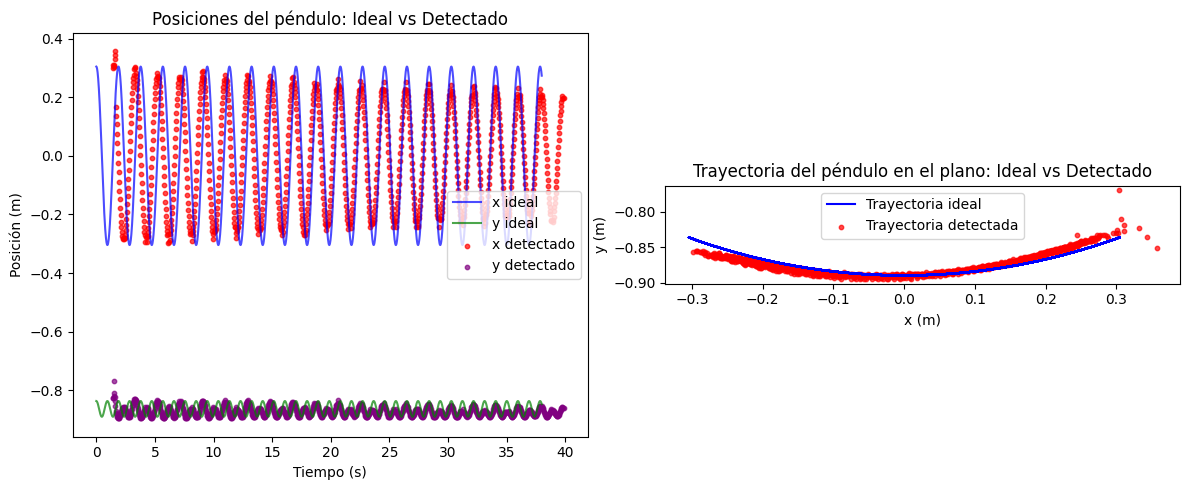

In [ ]:
# --- Gráficas ---
plt.figure(figsize=(12,5))

# (x,y) vs tiempo con ruido
plt.subplot(1,2,1)
plt.plot(t, x, label="x ideal", color="blue", alpha=0.7)
plt.plot(t, y, label="y ideal", color="green", alpha=0.7)
# Plot detected x and y over time
plt.scatter(detected_centroid_times, detected_x_m, label="x detectado", color="red", s=10, alpha=0.7)
plt.scatter(detected_centroid_times, -detected_y_m, label="y detectado", color="purple", s=10, alpha=0.7)
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (m)")
plt.title("Posiciones del péndulo: Ideal vs Detectado")
plt.legend()

# Trayectoria en el plano (x,y) con ruido
plt.subplot(1,2,2)
plt.plot(x, y, label="Trayectoria ideal", color="blue")
# Plot detected trajectory
plt.scatter(detected_x_m, -detected_y_m, label="Trayectoria detectada", color="red", s=10, alpha=0.7)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Trayectoria del péndulo en el plano: Ideal vs Detectado")
plt.gca().set_aspect('equal')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from scipy.signal import savgol_filter, find_peaks
from numpy.fft import rfft, rfftfreq
import numpy as np # Ensure numpy is imported here

# ---------- 1) Ángulo y preprocesamiento ----------
def angle_from_xy(x, y):
    # y apunta hacia abajo; el "vertical" hacia abajo es -y en la convención usual
    theta = np.arctan2(x, -y)        # [-pi, pi]
    return np.unwrap(theta)          # continuo

def preprocess_theta(theta, window_pts=101, poly=3):
    # Suaviza levemente (ajusta window_pts según tu dt y frecuencia)
    if window_pts % 2 == 0:
        window_pts += 1
    theta_s = savgol_filter(theta, window_pts, poly)
    return theta_s

# ---------- 2) Métricas de período ----------
def period_from_peaks(t, theta_s, prominence=1e-3, distance_pts=None):
    # detecta picos de theta; para oscilaciones pequeñas, picos ~ máximos de ángulo
    peaks, _ = find_peaks(theta_s, prominence=prominence, distance=distance_pts)
    if len(peaks) < 2:
        return np.nan, np.nan, peaks
    periods = np.diff(t[peaks])
    return np.nanmean(periods), np.nanstd(periods, ddof=1), peaks

def period_from_zerocross(t, theta_s):
    # cruces por cero con pendiente positiva
    s = np.sign(theta_s)
    # índices donde pasa de negativo a positivo
    idx = np.where((s[:-1] < 0) & (s[1:] > 0))[0]
    # interpola linealmente el cruce exacto
    t_cross = t[idx] - theta_s[idx]*(t[idx+1]-t[idx])/(theta_s[idx+1]-theta_s[idx])
    if len(t_cross) < 2: # Need at least two positive-going zero crossings for one period
        return np.nan, np.nan, t_cross
    # Calculate periods between every other zero crossing (positive-going to positive-going)
    periods = np.diff(t_cross)[::2]
    if len(periods) == 0:
         return np.nan, np.nan, t_cross
    return np.nanmean(periods), np.nanstd(periods, ddof=1), t_cross


def period_from_acf(t, theta_s):
    # autocorrelación (normalizada); busca el primer máximo tras el retardo 0
    x = theta_s - np.mean(theta_s)
    acf = np.correlate(x, x, mode='full')
    acf = acf[acf.size//2:]
    acf /= acf[0]
    # tiempo de muestreo
    dt = np.mean(np.diff(t))
    # omite los primeros lags pequeños para evitar el pico trivial
    start = int(0.1 / dt) if dt>0 else 1
    # busca máximo en una ventana razonable (p.ej., hasta 1/2 del registro)
    end = len(acf)//2
    if end <= start:
        return np.nan
    lag_peak = start + np.argmax(acf[start:end])
    return np.nan if lag_peak * dt <= 0 else lag_peak * dt

def period_from_fft(t, theta_s):
    # espectro y pico de frecuencia
    dt = np.mean(np.diff(t))
    N  = len(t)
    X  = rfft(theta_s - np.mean(theta_s))
    f  = rfftfreq(N, dt)
    # evita f=0
    if len(f) < 2:
        return np.nan
    idx = np.argmax(np.abs(X[1:])) + 1
    f0 = f[idx]
    return np.nan if f0 <= 0 else 1.0/f0

# ---------- 3) Estimación integral + bootstrap opcional ----------
def estimate_periods(t, x, y, smooth_window=101, smooth_poly=3, do_bootstrap=False, B=500, random_state=0):
    # Ensure t is a numpy array
    t = np.asarray(t)

    theta = angle_from_xy(x, y)
    theta_s = preprocess_theta(theta, smooth_window, smooth_poly)

    T_peaks_mean, T_peaks_std, peaks = period_from_peaks(t, theta_s)
    T_zero_mean,  T_zero_std,  zc    = period_from_zerocross(t, theta_s)
    T_acf = period_from_acf(t, theta_s)
    T_fft = period_from_fft(t, theta_s)

    results = {
        "peaks_mean": T_peaks_mean,
        "peaks_std" : T_peaks_std,
        "zero_mean" : T_zero_mean,
        "zero_std"  : T_zero_std,
        "acf"       : T_acf,
        "fft"       : T_fft
    }

    # Bootstrap sobre períodos por picos (si hay suficientes ciclos)
    if do_bootstrap and np.isfinite(T_peaks_mean) and not np.isnan(T_peaks_std) and T_peaks_std>0:
        rng = np.random.default_rng(random_state)
        # Períodos individuales entre picos
        if len(peaks) >= 2:
            per = np.diff(t[peaks])
            if len(per) >= 3:
                boots = []
                for _ in range(B):
                    sample = rng.choice(per, size=len(per), replace=True)
                    boots.append(np.mean(sample))
                ci_low, ci_high = np.percentile(boots, [2.5, 97.5])
                results["peaks_bootstrap_95CI"] = (ci_low, ci_high)

    return results

In [ ]:
# Call estimate_periods with the experimental data and their corresponding time array
results = estimate_periods(detected_centroid_times, detected_x_m, detected_y_m, smooth_window=101, smooth_poly=3, do_bootstrap=True, B=1000)

In [ ]:
print("Resultados de la estimación del período del péndulo:")
print("-" * 40)

# Imprimir y explicar cada métrica
for key, value in results.items():
    explanation = ""
    if key == "peaks_mean":
        explanation = f"Período promedio estimado a partir de la distancia entre picos consecutivos del ángulo suavizado."
    elif key == "peaks_std":
        explanation = f"Desviación estándar de los períodos estimados a partir de los picos. Indica la variabilidad en las mediciones del período."
    elif key == "zero_mean":
        explanation = f"Período promedio estimado a partir de los cruces por cero del ángulo suavizado."
    elif key == "zero_std":
        explanation = f"Desviación estándar de los períodos estimados a partir de los cruces por cero."
    elif key == "acf":
        explanation = f"Período estimado utilizando la función de autocorrelación. Representa el retardo en el que la señal se parece más a sí misma."
    elif key == "fft":
        explanation = f"Período estimado utilizando la Transformada Rápida de Fourier (FFT). Es el inverso de la frecuencia con mayor amplitud en el espectro de la señal."
    elif key == "peaks_bootstrap_95CI":
        explanation = f"Intervalo de confianza del 95% para el período estimado por picos, calculado mediante bootstrap. Proporciona un rango plausible para el valor real del período."
    else:
        explanation = "Métrica desconocida."

    print(f"- {key}: {value}")
    print(f"  Explicación: {explanation}\n")

Resultados de la estimación del período del péndulo:
----------------------------------------
- peaks_mean: 1.7947566137566138
  Explicación: Período promedio estimado a partir de la distancia entre picos consecutivos del ángulo suavizado.

- peaks_std: 0.3993799474138137
  Explicación: Desviación estándar de los períodos estimados a partir de los picos. Indica la variabilidad en las mediciones del período.

- zero_mean: nan
  Explicación: Período promedio estimado a partir de los cruces por cero del ángulo suavizado.

- zero_std: nan
  Explicación: Desviación estándar de los períodos estimados a partir de los cruces por cero.

- acf: 0.07229520331867749
  Explicación: Período estimado utilizando la función de autocorrelación. Representa el retardo en el que la señal se parece más a sí misma.

- fft: 1.926667168442755
  Explicación: Período estimado utilizando la Transformada Rápida de Fourier (FFT). Es el inverso de la frecuencia con mayor amplitud en el espectro de la señal.

- peaks

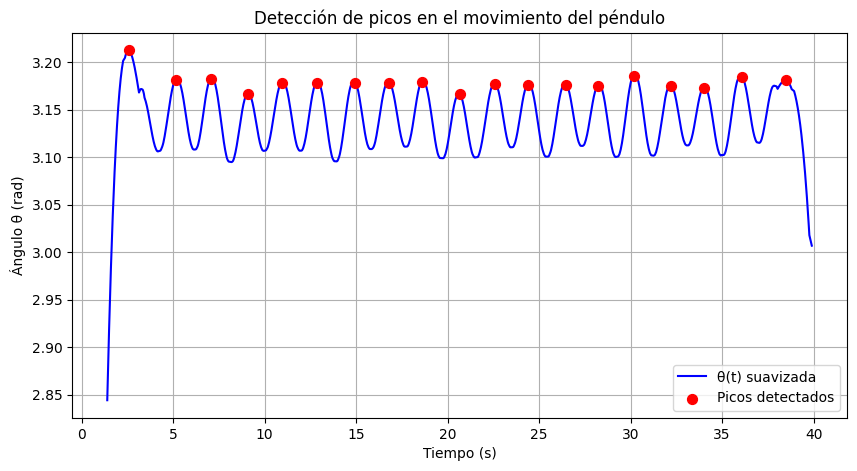

In [ ]:

# --- reconstruir ángulo a partir de datos (x,y) ---
# Use the detected x and y coordinates, which correspond to the detected_centroid_times
theta = np.arctan2(detected_x_m, -detected_y_m)     # en radianes
theta = np.unwrap(theta)

# --- suavizar para reducir ruido ---
theta_s = savgol_filter(theta, 101, 3)    # ventana 101, polinomio grado 3

# --- detectar picos ---
# Use the time values corresponding to the detected centroids for peak detection
# distance_pts should be related to the expected period in terms of number of data points
# A distance of 50 points might be too small depending on the sampling rate and period.
# Let's try to estimate a better distance based on the typical period.
# A period of ~1.9s (from theoretical) with ~30 fps means ~57 frames/points per period.
# Half a period (distance between peaks) would be ~28 points. Let's use 30 as a starting point.
# prominence can also be adjusted based on the amplitude of the oscillations.
peaks, _ = find_peaks(theta_s, prominence=np.std(theta_s)*0.5, distance=30) # Adjust parameters as needed

# --- graficar ---
plt.figure(figsize=(10,5))
# Plot the smoothed detected angle against the detected centroid times
plt.plot(detected_centroid_times, theta_s, label="θ(t) suavizada", color="blue")
# Plot the detected peaks using the detected centroid times
plt.scatter(np.array(detected_centroid_times)[peaks], theta_s[peaks], color="red", s=50, zorder=3, label="Picos detectados")
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulo θ (rad)")
plt.title("Detección de picos en el movimiento del péndulo")
plt.legend()
plt.grid(True)
plt.show()

# Estimación de Parámetros a partir de $x(t)$


In [ ]:
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

np.set_printoptions(precision=6, suppress=True)

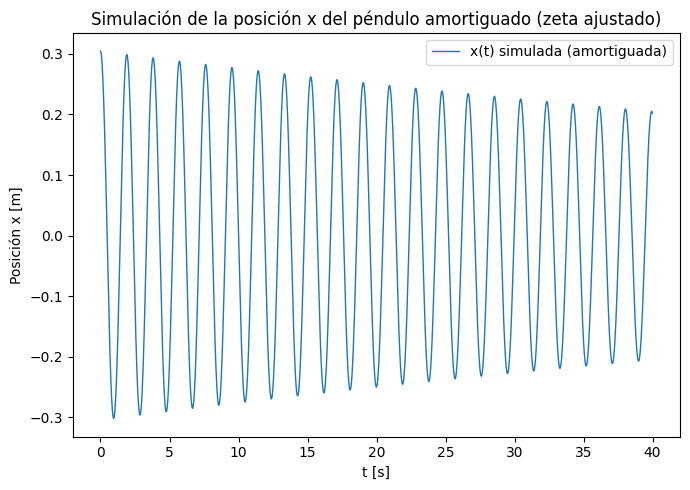

Amplitud máxima simulada: 0.3043 m
Amplitud mínima simulada: -0.3016 m


In [ ]:
from scipy.integrate import solve_ivp

# Parámetros físicos del péndulo real
L = 0.89       # Longitud del péndulo en metros
g = 9.81       # Gravedad (m/s^2)
theta0 = 0.349 # Ángulo inicial en radianes (~20°)

# Razón de amortiguamiento (ejemplo: ajusta este valor)
# Se aumenta ligeramente el valor de zeta para hacer el amortiguamiento un poco más visible
zeta = 0.003 # Razón de amortiguamiento adimensional (valor ajustado)
omega0 = np.sqrt(g / L) # Frecuencia natural no amortiguada

# Sistema de primer orden usando zeta
def damped_pendulum_ode(t, y, omega0, zeta):
    theta, omega = y # y = [theta, d(theta)/dt]
    dydt = [omega, -2 * zeta * omega0 * omega - omega0**2 * np.sin(theta)]
    return dydt

# Condiciones iniciales [ángulo inicial, velocidad angular inicial]
y0 = [theta0, 0.0] # Empezamos con velocidad angular cero

# Tiempo de simulación
t_span = [0, 40] # Rango de tiempo [inicio, fin]
t_eval = np.arange(t_span[0], t_span[-1], 0.01) # Puntos de tiempo donde queremos la solución

# Resolver la ODE
sol = solve_ivp(damped_pendulum_ode, t_span, y0, t_eval=t_eval, args=(omega0, zeta))

# Extraer los resultados
t_simulated = sol.t
theta_simulated = sol.y[0]
# omega_simulated = sol.y[1] # Velocidad angular simulada (no necesaria para la posición x)

# Convertir coordenadas polares (L, θ) a cartesianas simuladas
x_simulated = L * np.sin(theta_simulated)
y_simulated = -L * np.cos(theta_simulated) # No necesaria para la simulación de x

# Graficar la serie de tiempo simulada (solo x)
plt.figure(figsize=(7,5))
plt.plot(t_simulated, x_simulated, lw=1, label="x(t) simulada (amortiguada)")
plt.xlabel("t [s]"); plt.ylabel("Posición x [m]"); plt.title("Simulación de la posición x del péndulo amortiguado (zeta ajustado)")
plt.legend()
plt.tight_layout()
plt.show()

# Imprimir la amplitud máxima y mínima de la simulación para verificar la oscilación
print(f"Amplitud máxima simulada: {np.max(x_simulated):.4f} m")
print(f"Amplitud mínima simulada: {np.min(x_simulated):.4f} m")

# Las variables t_simulated y x_simulated ahora contienen la simulación de la posición x a lo largo del tiempo.

<Figure size 1200x600 with 0 Axes>

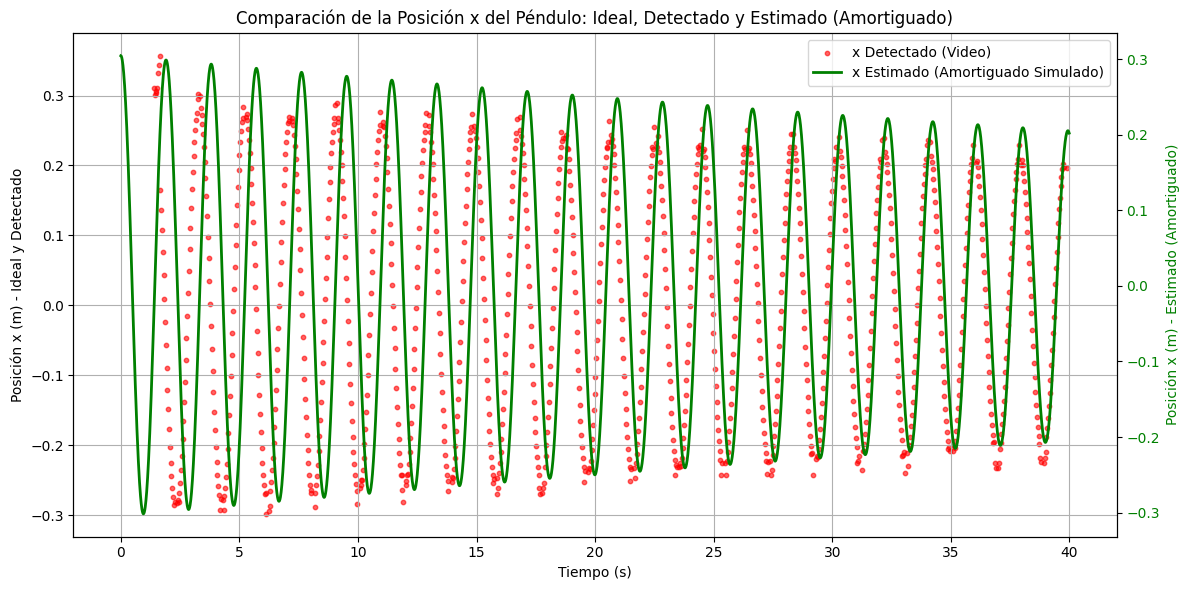

In [ ]:
# Create a single plot to compare ideal, detected, and simulated damped x positions

plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot ideal x position (calculated over detected time range in cell 4b47fbee)
# Ensure t_ideal_plot and x_ideal are available
if 't_ideal_plot' in globals() and 'x_ideal' in globals():
    ax1.plot(t_ideal_plot, x_ideal, label="x Ideal (No Amortiguado)", color="blue", linestyle='--')
else:
    print("Warning: Ideal data (t_ideal_plot, x_ideal) not found. Please run cell 4b47fbee.")


# Plot detected x position (from video analysis in cell 7f55df8d)
# Ensure detected_centroid_times and detected_x_m are available
if 'detected_centroid_times' in globals() and 'detected_x_m' in globals():
    ax1.scatter(detected_centroid_times, detected_x_m, label="x Detectado (Video)", color="red", s=10, alpha=0.6)
    ax1.set_ylabel("Posición x (m) - Ideal y Detectado")
else:
    print("Warning: Detected data (detected_centroid_times, detected_x_m) not found.")


# Plot simulated damped x position on a secondary y-axis
# Ensure t_simulated and x_simulated are available from the damped simulation cell
if 't_simulated' in globals() and 'x_simulated' in globals():
    ax2 = ax1.twinx() # Create a twin Axes sharing the x-axis
    ax2.plot(t_simulated, x_simulated, label="x Estimado (Amortiguado Simulado)", color="green", linewidth=2)
    ax2.set_ylabel("Posición x (m) - Estimado (Amortiguado)", color="green")
    ax2.tick_params(axis='y', labelcolor="green")
else:
     print("Warning: Simulated damped data (t_simulated, x_simulated) not found. Please run cell rs5V4lmAV64.")

# Add titles and legends
ax1.set_xlabel("Tiempo (s)")
ax1.set_title("Comparación de la Posición x del Péndulo: Ideal, Detectado y Estimado (Amortiguado)")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax1.grid(True)
# ax2.grid(True) # Avoid double grid lines

plt.tight_layout()
plt.show()

In [ ]:
desv_detectado = np.std(detected_x_m)
desv_estimado = np.std(x_simulated)
print("Desviación estándar detectado:", desv_detectado)
print("Desviación estándar estimado:", desv_estimado )

error = desv_detectado - desv_estimado
print("Error en la estimación detectado vs. estimado:", error)


Desviación estándar detectado: 0.1743355368795048
Desviación estándar estimado: 0.17989103210508398
Error en la estimación detectado vs. estimado: -0.005555495225579188


In [ ]:
desv_ideal = np.std(x)
desv_estimado = np.std(x_simulated)
print("Desviación estándar ideal:", desv_ideal )
print("Desviación estándar estimado:", desv_estimado )

error = desv_estimado - desv_ideal
print("Error en la estimación estimado vs. ideal:", error)

Desviación estándar ideal: 0.21666638804225175
Desviación estándar estimado: 0.17989103210508398
Error en la estimación estimado vs. ideal: -0.03677535593716777


In [ ]:
print("Desviación estándar ideal:", desv_ideal )
print("Desviación estándar detectado", desv_detectado  )

error = desv_detectado- desv_ideal
print("Error en la estimación detectado vs. ideal:", error)

Desviación estándar ideal: 0.21666638804225175
Desviación estándar detectado 0.1743355368795048
Error en la estimación detectado vs. ideal: -0.04233085116274696


# Método A — Regresión de Derivadas

Estimaciones con el Método A:
  omega0 ≈ 1.277687 rad/s
  zeta   ≈ 0.012026
  k      ≈ 0.048975 N/m
  b_visc ≈ 0.000922 N·s/m


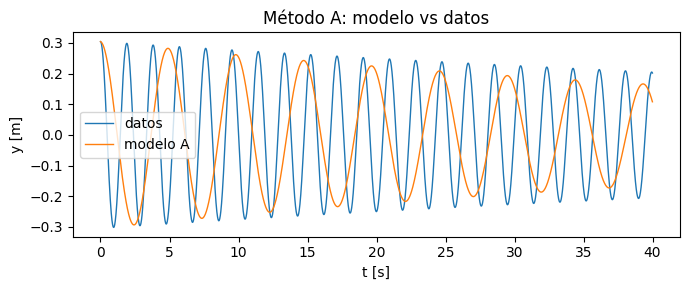

In [ ]:
def auto_window_length(N: int) -> int:
    # Calcula automáticamente una longitud de ventana adecuada (impar y >= 5)
    wl = max(5, (N // 10) | 1)   # ~1/10 de las muestras, impar
    wl = min(wl, N - (1 - (N % 2)))
    if wl < 5:
        wl = 5 if 5 % 2 == 1 else 7
    if wl >= N:
        wl = N-1 if (N-1) % 2 == 1 else N-2
        if wl < 5:
            wl = 5
    return int(wl)

def fit_derivative_regression(t, y, poly=3, window_length=None):
    """
    Ajusta el modelo lineal de regresión de derivadas:
        y'' = -a y' - b y

    Args:
        t: vector de tiempos
        y: señal observada
        poly: orden del polinomio en el filtro Savitzky–Golay
        window_length: longitud de ventana para el suavizado

    Returns:
        Diccionario con a, b, omega0, zeta y las señales suavizadas y derivadas
    """
    t = np.asarray(t, float) # Corrected to use input parameter t
    y = np.asarray(y, float) # Corrected to use input parameter y
    dt = np.median(np.diff(t))
    if window_length is None:
        window_length = auto_window_length(len(t))
    window_length = int(window_length)

    # Señal suavizada y sus derivadas primera y segunda
    y_s = savgol_filter(y, window_length=window_length, polyorder=min(poly, window_length-1))
    yd = savgol_filter(y, window_length=window_length, polyorder=min(poly, window_length-1), deriv=1, delta=dt)
    ydd = savgol_filter(y, window_length=window_length, polyorder=min(poly, window_length-1), deriv=2, delta=dt)

    # Ajuste lineal: y'' = -a y' - b y
    X = np.column_stack([yd, y_s])
    rhs = -ydd
    theta, *_ = np.linalg.lstsq(X, rhs, rcond=None)
    a, b = theta

    # Parámetros físicos estimados
    omega0 = np.sqrt(abs(b))
    zeta = a / (2.0 * omega0) if omega0 > 0 else 0.0

    return dict(a=a, b=b, omega0=omega0, zeta=zeta, y_s=y_s, yd=yd, ydd=ydd)

# Add a placeholder for m_true
m_true = 0.03 # Placeholder value

# Ajuste con el Método A
A = fit_derivative_regression(t_simulated, x_simulated) # Use simulated data for fitting
k_A = m_true * (A["omega0"]**2)
b_A = 2 * m_true * A["zeta"] * A["omega0"]

print("Estimaciones con el Método A:")
print(f"  omega0 ≈ {A['omega0']:.6f} rad/s")
print(f"  zeta   ≈ {A['zeta']:.6f}")
print(f"  k      ≈ {k_A:.6f} N/m")
print(f"  b_visc ≈ {b_A:.6f} N·s/m")

# Opcional: construir una señal modelo integrando con k y b estimados
def simulate_ode(t, y0, v0, m, k, b):
    def f(_t, z):
        y, v = z
        return [v, -(b/m)*v - (k/m)*y]
    sol = solve_ivp(f, (t[0], t[-1]), [y0, v0], t_eval=t, method="RK45", rtol=1e-6, atol=1e-9)
    return sol.y[0]

# Condiciones iniciales
y0 = x_simulated[0] # Use initial value from simulated data
v0 = (x_simulated[1]-x_simulated[0]) / (t_simulated[1]-t_simulated[0]) # Use initial velocity from simulated data

# Simulación con los parámetros estimados
yhat_A = simulate_ode(t_simulated, y0, v0, m_true, k_A, b_A)

# Gráfico: comparación entre datos y modelo del Método A
plt.figure(figsize=(7,3))
plt.plot(t_simulated, x_simulated, lw=1, label="datos") # Plot simulated data
plt.plot(t_simulated, yhat_A, lw=1, label="modelo A") # Plot fitted model
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.title("Método A: modelo vs datos")
plt.legend()
plt.tight_layout()
plt.show()

# Método B — Ajuste de EDO (no lineal)

Estimaciones con el Método B:
  omega0 ≈ 3.301425 rad/s
  zeta   ≈ 0.002950
  k      ≈ 0.326982 N/m
  b_visc ≈ 0.000584 N·s/m


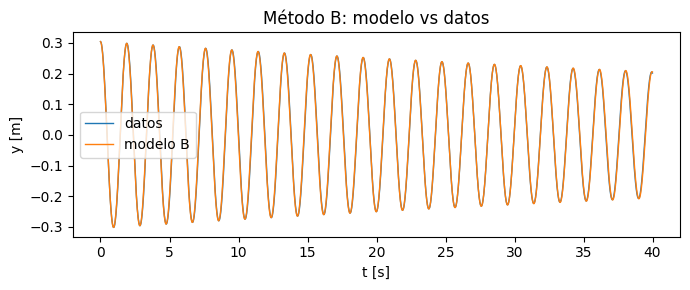

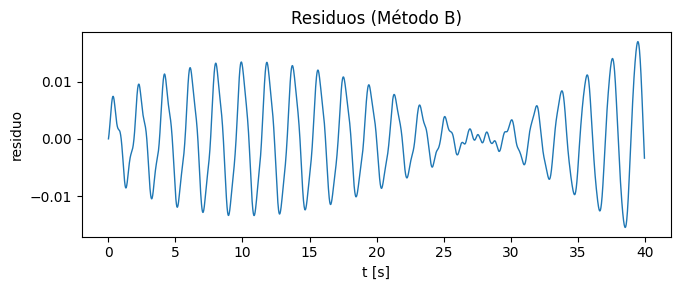

In [ ]:
m_true = 0.03 # Placeholder value - add this line to define m_true

def fit_ode(t, y, m, k0, b0):
    """
    Ajusta los parámetros k y b resolviendo la EDO y minimizando
    la suma de residuos al cuadrado.

    Args:
        t: vector de tiempos
        y: señal observada
        m: masa conocida
        k0, b0: valores iniciales de k y b (ej. estimados del Método A)

    Returns:
        Diccionario con k, b, omega0, zeta, la señal ajustada y el resultado de optimización
    """
    t = np.asarray(t, float) # Corrected to use input parameter t
    y = np.asarray(y, float) # Corrected to use input parameter y
    dt = np.median(np.diff(t))
    y0 = y[0]
    v0 = (y[1]-y[0])/dt if len(t) > 1 else 0.0  # velocidad inicial

    # Simulación de la EDO para un par (k,b)
    def simulate(k, b):
        def f(_t, z):
            yy, vv = z
            return [vv, -(b/m)*vv - (k/m)*yy]
        sol = solve_ivp(f, (t[0], t[-1]), [y0, v0],
                        t_eval=t, method="RK45", rtol=1e-6, atol=1e-9)
        return sol.y[0]

    # Función de residuos (diferencia entre datos y modelo)
    def residual(theta):
        k, b = theta
        yhat = simulate(k, b)
        return yhat - y

    # Optimización no lineal con mínimos cuadrados robustos
    res = least_squares(residual,
                        x0=np.array([k0, b0]),
                        bounds=([1e-9, 0.0],[np.inf, np.inf]),
                        method="trf",
                        loss="huber",
                        f_scale=1.0)

    k_fit, b_fit = res.x
    omega0 = np.sqrt(k_fit / m)
    zeta = b_fit / (2*m*omega0) if omega0 > 0 else 0.0
    yhat = simulate(k_fit, b_fit)

    return dict(k=k_fit, b=b_fit, omega0=omega0,
                zeta=zeta, yhat=yhat, result=res)

# Adjuste con el Método B, partiendo de los parámetros del Método A
# Ensure k_A, b_A, and m_true are defined before this cell is executed
# This cell depends on the output of the previous cell defining A (and thus k_A and b_A) and m_true
B = fit_ode(t_simulated, x_simulated, m_true, k_A, b_A) # Use simulated data for fitting

print("Estimaciones con el Método B:")
print(f"  omega0 ≈ {B['omega0']:.6f} rad/s")
print(f"  zeta   ≈ {B['zeta']:.6f}")
print(f"  k      ≈ {B['k']:.6f} N/m")
print(f"  b_visc ≈ {B['b']:.6f} N·s/m")

# Comparación datos vs modelo B
plt.figure(figsize=(7,3))
plt.plot(t_simulated, x_simulated, lw=1, label="datos") # Plot simulated data
plt.plot(t_simulated, B["yhat"], lw=1, label="modelo B") # Plot fitted model
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.title("Método B: modelo vs datos")
plt.legend()
plt.tight_layout()
plt.show()

# Residuos del ajuste con Método B
plt.figure(figsize=(7,3))
plt.plot(t_simulated, x_simulated - B["yhat"], lw=1) # Use simulated data for residues
plt.xlabel("t [s]"); plt.ylabel("residuo")
plt.title("Residuos (Método B)")
plt.tight_layout()
plt.show()